# Module / DataModule / Trainer

Inspired by open-source libraries such as PyTorch Lightning 70 , at a high level we wish to have three classes: 
- (i) Module contains models, losses, and optimization methods; 
- (ii) DataModule provides data loaders for training and validation; 
- (iii) both classes are combined using the Trainer class, which allows us to train models on a variety of hardware platforms.

In [1]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## Step 1: Define the Model

At the very least we need three methods. 
- The first, __init__, stores the learnable parameters, 
- the __training_step__ method accepts a data batch to return the loss value, 
- and finally, __configure_optimizers__ returns the optimization method, or a list of them, that is used to update the learnable parameters. 

Optionally we can define 
- __validation_step__ to report the evaluation measures. 

Sometimes we put the code for computing the output into a separate __forward__ method to
make it more reusable.

In [2]:
class Module(nn.Module, d2l.HyperParameters):  #@save
    # You may notice that Module is a subclass of nn.Module, the base class of neural networks in PyTorch.
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__() # invokes the initializer (__init__ method) of a parent (or superclass) when you’re working with class inheritance.
        self.save_hyperparameters()
        self.board = d2l.ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError
    
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)
    
    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
        
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

## Step 2: Set Up the data

- Quite frequently the __init__ method is used to prepare the data. This includes downloading and preprocessing if needed. 

- The __train_dataloader__ returns the data loader for the training dataset. A data loader is a (Python) generator that yields a data batch each time it is used. This batch is then fed into the __training_step__ method of Module to compute the loss. 

- There is an optional __val_dataloader__ to return the validation dataset loader. It behaves in the same manner, except that it yields data batches for the validation_step method in Module.

In [3]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()
    def get_dataloader(self, train):
        raise NotImplementedError
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    def val_dataloader(self):
        return self.get_dataloader(train=False)


## Step 3: Prepare for training

The __Trainer__ class trains the learnable parameters in the Module class with data specified in DataModule. 

- The key method is __fit__, which accepts two arguments: model, an instance of Module, and data, an instance of DataModule. 

- It then iterates over the entire dataset __max_epochs__ times to train the model. As before, we will defer the implementation of this method to later chapters.

In [4]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'
    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)
    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    def fit_epoch(self):
        raise NotImplementedError

## Synthetic Data creation

In the example in th enext Notebook (Linear regression), we will use a syntthetic dataset, created to illustrate the imlementation on the NN for Liner Regression. Here you can take a look at how this is done:

In [5]:
import random

In [6]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=5000, num_val=5000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise
        # -1 is a special value in NumPy that means: “automatically calculate this dimension 
        # based on the array’s total size.”


In [7]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

In [8]:
print('features:', data.X[0],'\nlabel:', data.y[0])
print('number of training examples:', data.num_train)
print('number of validation examples:', data.num_val)

features: tensor([-0.6652,  0.2179]) 
label: tensor([2.1375])


Now create the trianloader to load the train set in batches to pass to the training

In [9]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        # Pauses Execution and Returns a Value: When a generator function encounters a yield statement, 
        # it pauses its execution and returns the value specified by yield to the caller.
        yield self.X[batch_indices], self.y[batch_indices] 


In [10]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

#  NOTE:
# iter(...) The iter() function is a built-in Python function that 
# returns an iterator from an iterable. In this case, it turns the 
# data loader (which is iterable) into an explicit iterator. 
# This allows you to manually retrieve elements using next().

# next(...)
# The next() function retrieves the next item from the iterator 
# — in this context, it gives you the first batch of data from the 
# data loader.

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


Rather than writing our own iterator, we can call the existing API in a framework to load data. 

In [11]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [12]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


## Exercizes

### Ex 1:

Locate full implementations of the above classes that are saved in the D2L library. We strongly recommend that you look at the implementation in detail once you have gained some more familiarity with deep learning modeling.

https://github.com/d2l-ai/d2l-en/tree/master/d2l


### Ex 2: Do the following:

- print the shape of the input X and the label y generated in the example in cell 14
- print the length for the train_dataloader object: what does this correspond to?

### Ex 3:

The code below plots the data set that has been simulated before. Can you overlay the ground truth?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


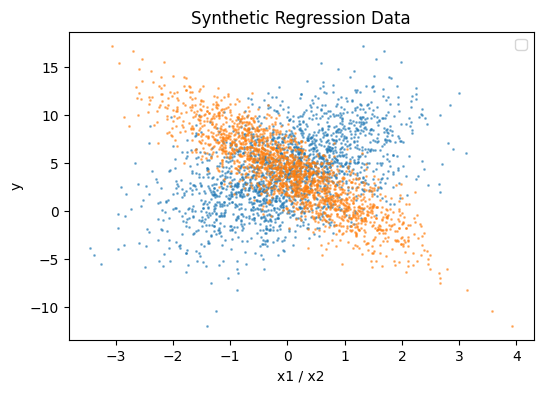

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(data.X[:, 0].detach().numpy(), data.y.detach().numpy(),
            1, color='C0', alpha=0.5)
plt.scatter(data.X[:, 1].detach().numpy(), data.y.detach().numpy(),
            1, color='C1', alpha=0.5)
# Hint: create and X array and the function y = 2*x + 4.2 and - 3.4*x2 to plot the ground truth
# ...
# ...

plt.legend()
plt.xlabel('x1 / x2')
plt.ylabel('y')
plt.title('Synthetic Regression Data')
plt.show()